# An introduction to PanelSplit

In this introduction, we see how PanelSplit's cross-validation abilities can be used for imputation, hyper-parameter tuning, and prediction.

Let's import some panel data on countries using the World Bank API:
First let's install PanelSplit and wbdata

In [ ]:
!pip install panelsplit > /dev/null # installation of PanelSplit
!pip install wbdata > /dev/null # installation of wbdata

from panelsplit.cross_validation import PanelSplit
import wbdata
import pandas as pd; import numpy as np

Load the example dataframe:

In [2]:
import pandas as pd; import numpy as np

# Define indicators and countries of interest
indicators = {"NY.GDP.MKTP.CD": "GDP",  # Gross Domestic Product (current US$)
              "SP.POP.TOTL": "Population",  # Total population
              "FP.CPI.TOTL.ZG": "Inflation",     # Inflation, consumer prices (annual %)
              "NE.TRD.GNFS.ZS": "Trade_Balance"}    # Trade balance (% of GDP)

countries = ["USA", "GBR", "FRA", "DEU", "ESP"]  # Example countries: USA, UK, France, Germany

features, target  = ['Population','Inflation','Trade_Balance'], 'GDP' # Define feature columns and target

# Fetch data from the World Bank API
df = wbdata.get_dataframe(indicators, country=countries).reset_index()
df['date'] = df.date.astype(int)
df = df.query('date > 2000 & date < 2020')

print('a sample of the data:')
display(df.sample(5))
print('summary statistics:')
print(df.describe())

a sample of the data:


,country,date,GDP,Population,Inflation,Trade_Balance
45,France,2005,2.192146e+12,63179351.0,1.745869,55.822836
445,United States,2001,1.058193e+13,284968955.0,2.826171,22.967183
158,Germany,2017,3.763092e+12,82657002.0,1.509495,77.566637
48,France,2008,2.926803e+12,64374984.0,2.812862,59.179793
259,Spain,2017,1.321754e+12,46593236.0,1.956076,66.167446


summary statistics:
              date           GDP    Population  Inflation  Trade_Balance
count    95.000000  9.500000e+01  9.500000e+01  95.000000      95.000000
mean   2010.000000  5.045989e+12  1.125899e+08   1.810170      54.990272
std       5.506283  5.538265e+12  9.920676e+07   1.028464      15.921591
min    2001.000000  6.277987e+11  4.085041e+07  -0.500366      22.286384
25%    2005.000000  1.900739e+12  6.062401e+07   1.383449      52.398997
50%    2010.000000  2.722794e+12  6.599869e+07   1.745869      58.152561
75%    2015.000000  3.808436e+12  8.250238e+07   2.450895      63.573721
max    2019.000000  2.153998e+13  3.295340e+08   4.075343      79.300488


Say we don't have all the data available- ~10% of the features are missing at random.

In [3]:
for i, col in enumerate(df[features].columns):
    df.loc[df.sample(frac=0.1, random_state=i).index, col] = np.nan

print('proportion of features that are missing:')
round(df[features].isna().mean(), 4)

proportion of features that are missing:


Population       0.1053
Inflation        0.1053
Trade_Balance    0.1053
dtype: float64

We can use PanelSplit to apply imputation in a time-series fashion to fill in the missing data.

#### Initializing PanelSplit
- To initialize PanelSplit, we pass the time series to the periods argument.
- n_splits, gap, and test_size are all arguments used by [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to split up the time series.
- When we specify `plot=True`, a graph is displayed. This is a helpful visualization to understand what this particular instance of PanelSplit is doing. By reading this graph, we see that there are 19 folds or splits, that range from 2001 up to 2020. Train sets are marked in blue and test sets are marked in red.

#### `cross_val_fit_predict`
- The cross_val_fit_predict function takes an estimator. This could include a classifier, regressor, or even a tranformer in our case. The `method` argument allows us to specify any method that's available to our estimator. Here we use `"transform"`.
- It iteratively fits on the train and transforms the test for each fold. 
- By setting `include_first_train_in_test=True` in PanelSplit, we also include transform the first split's training data.
- We set `y = None` because our imputer does not require y as an input.


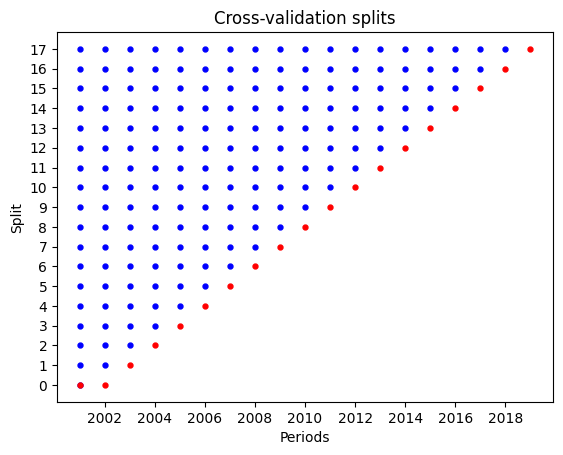

In [15]:
from sklearn.impute import KNNImputer
from panelsplit.plot import plot_splits
from panelsplit.application import cross_val_fit_predict

n_splits = df.date.max()-df.date.min()

# converting the date column to datetime allows for a nice looking plot.
# include_first_train_in_test determines whether to include the first split's training set in its test set.
panel_split = PanelSplit(periods=pd.to_datetime(df.date, format='%Y'), n_splits = n_splits, gap=0, test_size=1, include_first_train_in_test=True) 

plot_splits(panel_split, show=True)

df[features], fitted_imputers = cross_val_fit_predict(estimator = KNNImputer(), X= df[features], y =None,  method = 'transform', cv = panel_split)

Now that all observations have all features, we can determine the best set of hyper-parameters to use.

#### Hyper-parameter search

Since PanelSplit is compatible with sklearn, we can use any sklearn hyper-parameter optimizer has takes cv as an argument.

Let's say that our validation period is 2010-2015 and our test period is 2016-2020.


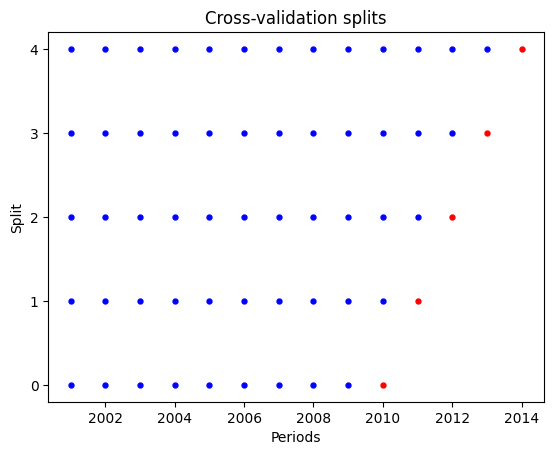

Fitting 5 folds for each of 2 candidates, totalling 10 fits
GridSearch results:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.051493,0.003692,0.024476,0.003536,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.950969,0.982368,0.977855,0.968894,0.055657,0.787149,0.365904,2
1,0.046349,0.005266,0.022615,0.001505,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.973170,0.981814,0.993803,0.987333,0.031394,0.793503,0.381115,1


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

validation_df = df.query('date < 2015')

param_grid = {'max_depth': [3, 5], 'n_estimators': [10]}
panel_split = PanelSplit(validation_df.date, n_splits=5, gap=0, test_size=1)

plot_splits(panel_split)

grid_search = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), param_grid=param_grid, cv = panel_split, n_jobs=-1, verbose = 1)

grid_search.fit(validation_df[features], validation_df[target])

print('GridSearch results:')
display(pd.DataFrame(grid_search.cv_results_))

Now that we've determined what hyper-parameters to use, let's generate predictions in the test period.

#### `cross_val_fit_predict`
- PanelSplit's cross_val_fit_predict iteratively fits on the train and predicts the test for each fold
- Here are the arguments I use:
    - estimator: estimator object.
    - X: Features.
    - y: Target variable.
    - labels: pandas DataFrame containing labels for the target variable predicted by the model. The predicted target will be a new column added to this DataFrame.
    - prediction_method: The prediction method to use. It can be 'predict', 'predict_proba', or 'predict_log_proba'. Default is 'predict'.
    - y_pred_col: Column name for the predicted values. Default is None, in which case the name will be the name of y.name + 'pred'. If y does not have a name attribute, the name will be 'y_pred'.
    - n_jobs: The number of jobs to run in parallel

In [6]:
best_params = grid_search.best_params_

panel_split = PanelSplit(df.date, n_splits=5, gap=0, test_size=1)
result_df = panel_split.gen_test_labels(df[['country','date', 'GDP']])
result_df['GDP_pred'], models = cross_val_fit_predict(RandomForestRegressor(**best_params),  X= df[features], y=df[target], method='predict', cv= panel_split)

The output of cross_val_fit_predict is a dataframe of predictions and fitted models. This is what the DataFrame looks like:

Let's assess performance:

In [17]:
from sklearn.metrics import mean_absolute_percentage_error

print('MAPE:', round(mean_absolute_percentage_error(result_df.GDP, result_df.GDP_pred),2))

MAPE: 0.15


## Multiple Snapshots/Updated Values

There are also instances where you might want to keep observations seperate between folds, for example when scaling features. 

In case you need to manually implement something where observations must be handled differently across folds, PanelSplit's `gen_snapshots` converts a single df to multiple snapshots of that dataframe.

In [18]:
panel_split = PanelSplit(df.date, n_splits = (2020 - 2010), test_size=1)

snapshot_df = panel_split.gen_snapshots(df, period_col = 'date')
print('2 new columns are created: split and snapshot_period:')
display(snapshot_df)
print(f'before gen_snapshot:{df.shape} after gen_snapshot:{snapshot_df.shape}')

2 new columns are created: split and snapshot_period:


,country,date,GDP,Population,Inflation,Trade_Balance,split,snapshot_period
41,France,2001,1.370377e+12,61357430.0,1.634781,56.893233,0,2010
42,France,2002,1.492428e+12,61805267.0,1.923412,55.132525,0,2010
43,France,2003,1.835096e+12,115716188.6,2.098472,49.808744,0,2010
44,France,2004,2.109792e+12,62704895.0,2.142090,53.749765,0,2010
45,France,2005,2.192146e+12,63179351.0,1.745869,55.822836,0,2010
...,...,...,...,...,...,...,...,...
459,United States,2015,1.829502e+13,320635163.0,1.830298,27.688214,9,2019
460,United States,2016,1.880491e+13,322941311.0,1.261583,26.452598,9,2019
461,United States,2017,1.961210e+13,324985539.0,2.130110,27.125338,9,2019
462,United States,2018,2.065652e+13,326687501.0,2.442583,27.445359,9,2019


before gen_snapshot:(95, 6) after gen_snapshot:(725, 8)


Let's scale our data using `cross_val_fit_predict`. Here each snapshot is scaled separately. We also specify `include_train_in_test=True`, thereby also transforming the training set for each fold.

In [ ]:
from sklearn.preprocessing import StandardScaler

panel_split = PanelSplit(periods = snapshot_df.date, snapshots = snapshot_df.snapshot_period, n_splits = (2020 - 2010), include_train_in_test=True) # notice the usage of the snapshots argument. Also, include train in test means that the training data for each test set will be transformed as well.
snapshot_df[features], scalers = cross_val_fit_predict(StandardScaler(), X= snapshot_df[features], y=None, cv=panel_split, method='transform') # transform_train transforms the training set for each fold

We could then go on to hyper-parameter tune and cross_val_fit_predict our snapshot_df in almost the same way we did before. The only difference, like in the above cell, is that we specify the snapshots argument.